<a href="https://colab.research.google.com/github/theSC0RP/PyTorch-Deep-Learning/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torchvision import datasets, models, transforms

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

trainset = datasets.ImageFolder('/content/drive/My Drive/Datasets/natural_images/train', transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, 50, True)

testset = datasets.ImageFolder('/content/drive/My Drive/Datasets/natural_images/test', transform = transform)
testloader = torch.utils.data.DataLoader(testset, 50, True)

In [4]:
len(trainset.imgs)

4000

In [5]:
len(testset.imgs)

1600

In [0]:
images, labels = next(iter(trainloader))

In [7]:
images.shape

torch.Size([50, 3, 224, 224])

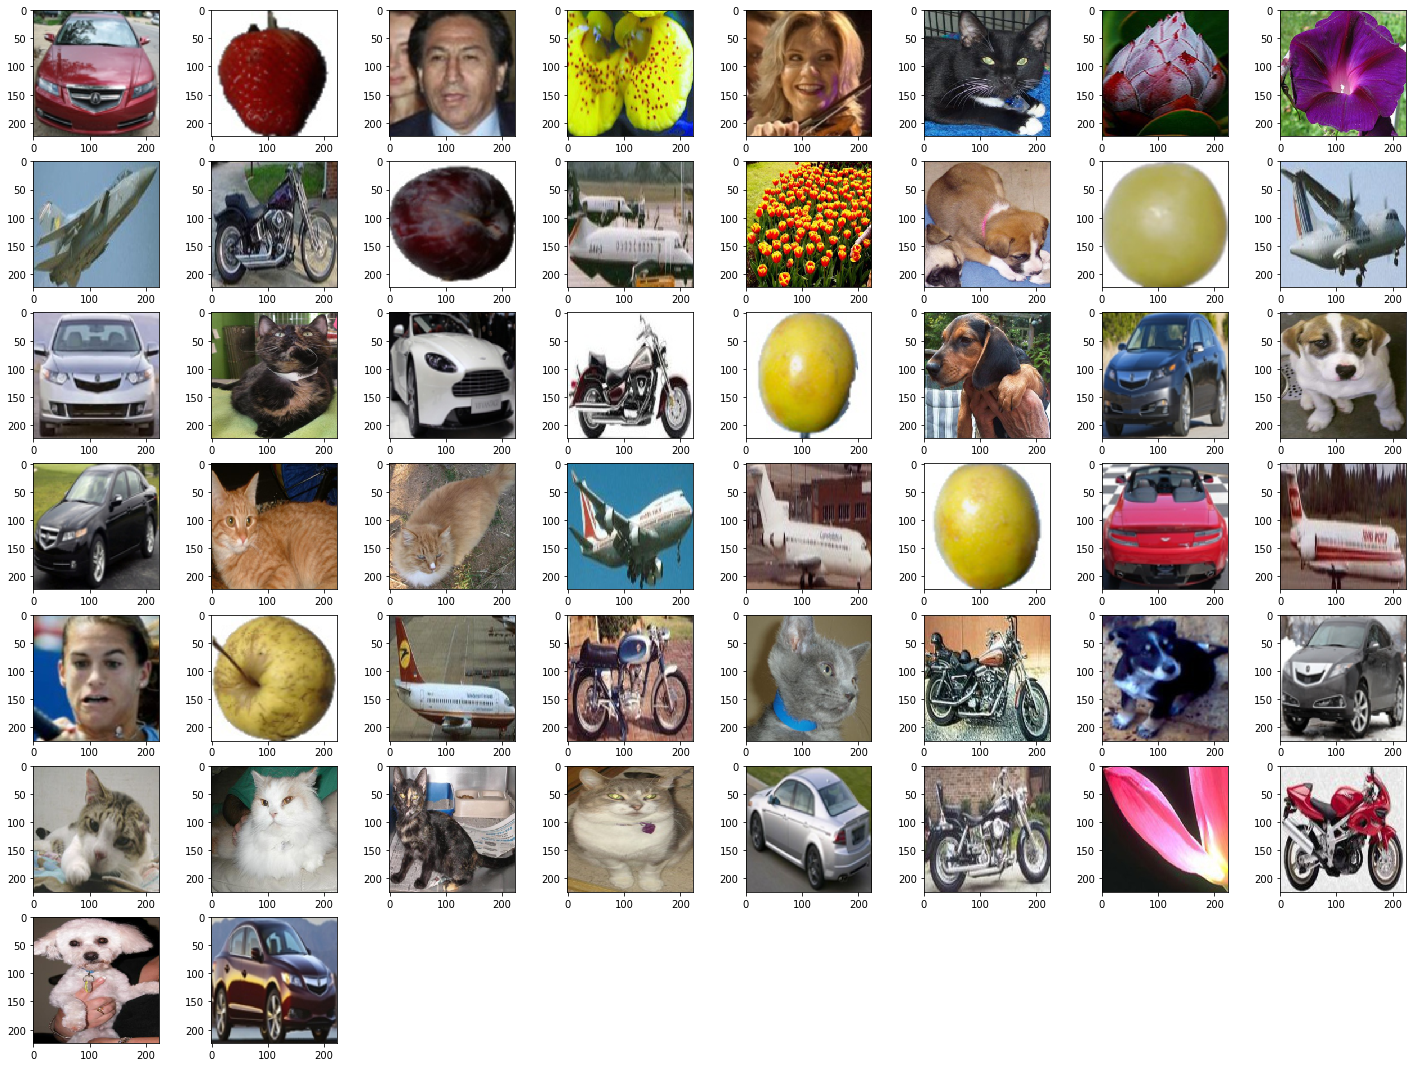

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25, 19))
for i in range(50):
  plt.subplot(7, 8, i+1)
  plt.imshow(images[i].permute(1, 2, 0))

In [0]:
model = models.vgg19(pretrained=True)

for param in model.parameters():
  param.requires_grad = False

In [10]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [0]:
# Extracting the fully connected layers from the network

classifier = list(model.classifier.children())

In [0]:
# Tweaking the Linear Layers

from torch import nn
from torch.nn import Linear, ReLU, Dropout

log_softmax = torch.nn.LogSoftmax(dim = 1)

classifier[3] = Linear(4096, 2048)
classifier[6] = Linear(2048, 1024)
additional_layers = [ReLU(True), Dropout(), Linear(1024, 8)]

classifier = classifier + additional_layers

In [0]:
# Changing the fully connected layers in the network

model.classifier = torch.nn.Sequential(*classifier) # '*' is used to unpack the list

In [14]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=2048, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=2048, out_features=1024, bias=True)
  (7): ReLU(inplace=True)
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=1024, out_features=8, bias=True)
)

In [0]:
# Moving model to GPU

model = model.to('cuda')
model = nn.DataParallel(model)

In [16]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

133,285,960 total parameters.
10,497,032 training parameters.


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 0.003)
num_epochs = 10

In [18]:
# Training the network

for e in range(num_epochs):
  running_loss = 0
  correct = 0
  for images, labels in trainloader:
    images = images.to('cuda')
    labels = labels.to('cuda')

    # Forward Pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    (max_vals, arg_maxs) = torch.max(outputs.data, dim=1)
    correct += torch.sum(labels == arg_maxs)

    # Backpropogation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss
  print("{}/{} ---> loss: {:.3f} accuracy: {:.2f}%".format(e+1, num_epochs, running_loss, correct / 40.0))

1/10 ---> loss: 156.420 accuracy: 34.75%
2/10 ---> loss: 130.819 accuracy: 72.38%
3/10 ---> loss: 96.145 accuracy: 89.05%
4/10 ---> loss: 60.597 accuracy: 94.43%
5/10 ---> loss: 37.929 accuracy: 95.70%
6/10 ---> loss: 25.475 accuracy: 96.58%
7/10 ---> loss: 18.918 accuracy: 97.08%
8/10 ---> loss: 14.777 accuracy: 97.58%
9/10 ---> loss: 12.283 accuracy: 97.60%
10/10 ---> loss: 10.950 accuracy: 97.70%


In [19]:
# Testing the network

with torch.no_grad():
  correct = 0
  for images, labels in testloader:
    images = images.to('cuda')
    labels = labels.to('cuda')
    outputs = model(images)
    
    (max_vals, arg_maxs) = torch.max(outputs.data, dim = 1)
    correct += torch.sum(arg_maxs == labels)
  print("Accuracy: {:.2f} %".format(correct / 16.0))

Accuracy: 97.31 %


In [0]:
activations = []
def forward_hook_fn(module, input, output):
  activations.append(output)

In [0]:
for name, module in list(model.module.features._modules.items()):
  module.register_forward_hook(forward_hook_fn)

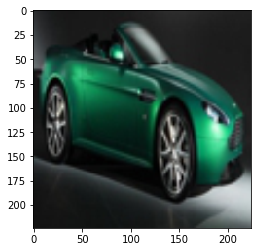

In [59]:
test_img = images[6].cpu()
plt.imshow(test_img.permute(1, 2, 0))

In [0]:
test_img = test_img.unsqueeze(0) # [3, 244, 244] ---> [1, 3, 244, 244]

In [0]:
test_img = test_img.to('cuda');
output = model(test_img)

In [44]:
# Dimensions of the Conv2d layer outputs

convs = [0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34]
for i in convs:
  print(activations[i].shape)

torch.Size([1, 64, 224, 224])
torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 112, 112])
torch.Size([1, 128, 112, 112])
torch.Size([1, 256, 56, 56])
torch.Size([1, 256, 56, 56])
torch.Size([1, 256, 56, 56])
torch.Size([1, 256, 56, 56])
torch.Size([1, 512, 28, 28])
torch.Size([1, 512, 28, 28])
torch.Size([1, 512, 28, 28])
torch.Size([1, 512, 28, 28])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])


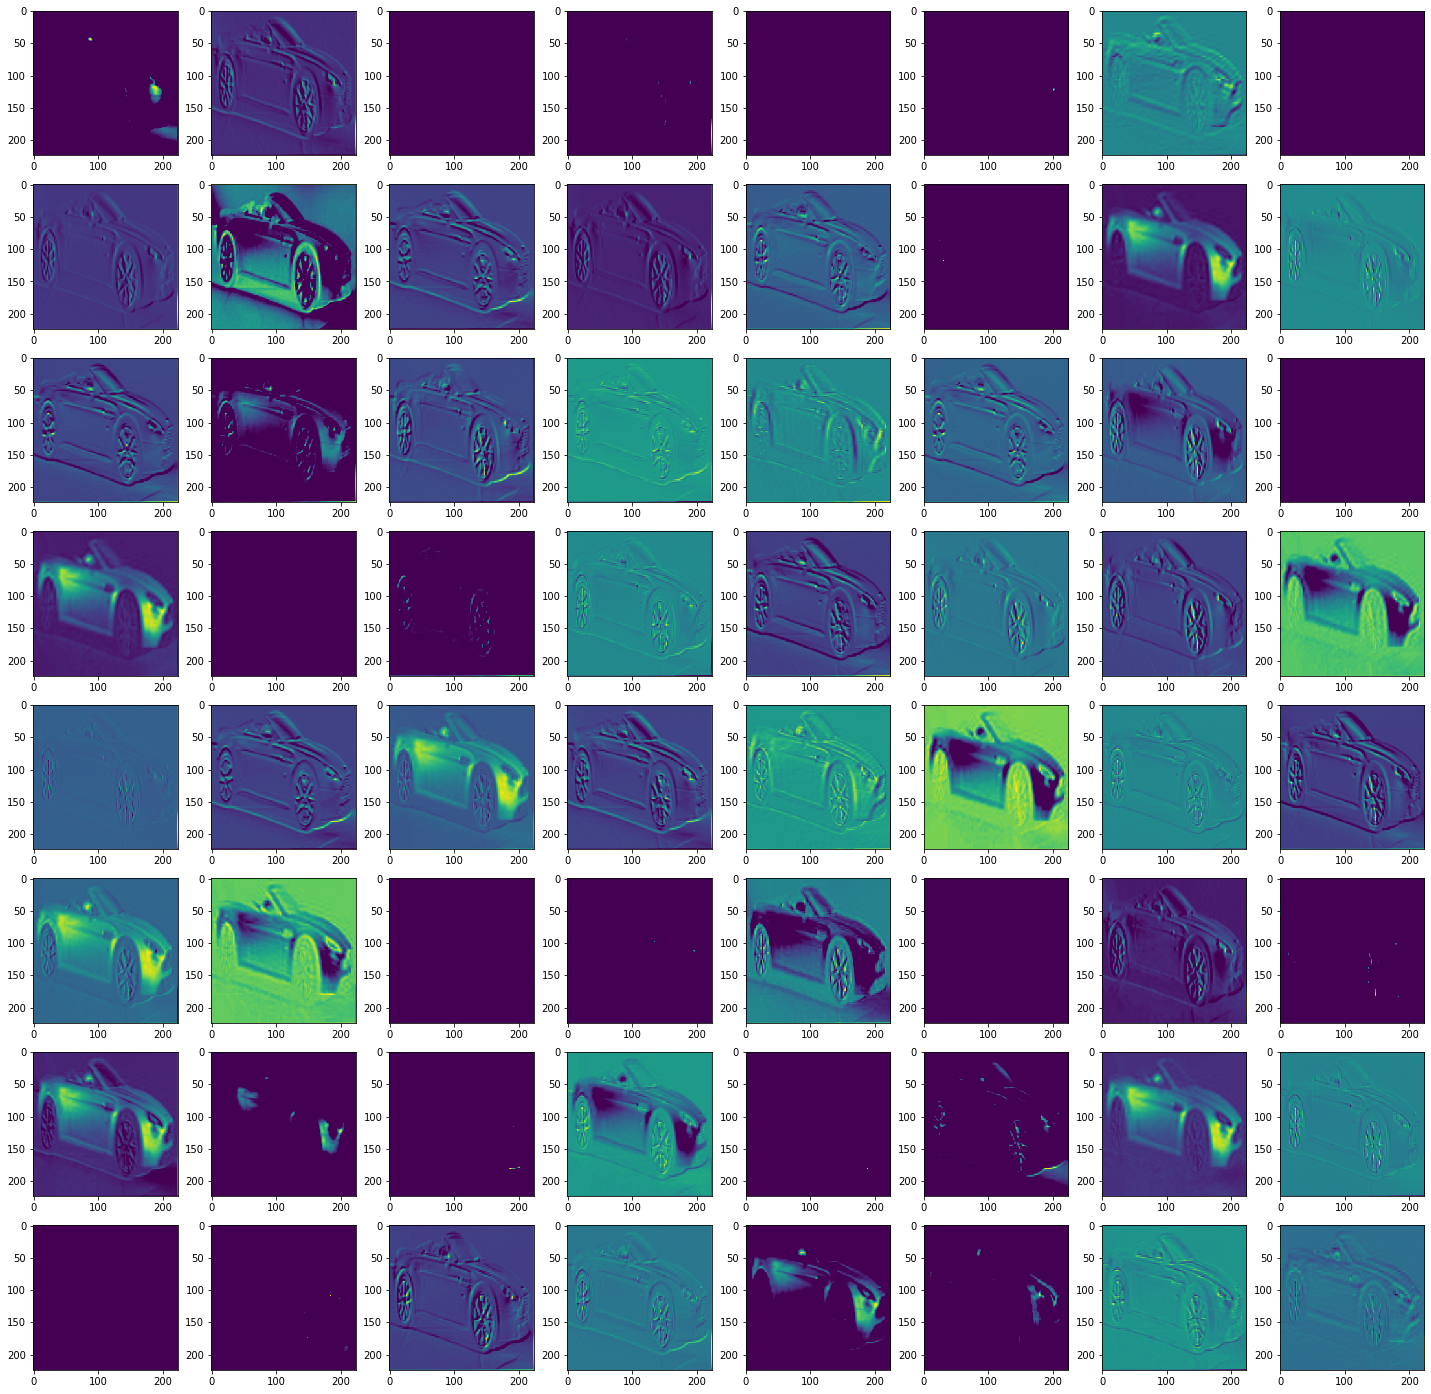

In [51]:
# Visualizing (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
# 64 x 224 x 224

plt.figure(figsize = (25, 25))
for i in range(activations[0][0].shape[0]):
  plt.subplot(8, 8, i+1)
  plt.imshow(activations[0][0][i].cpu())

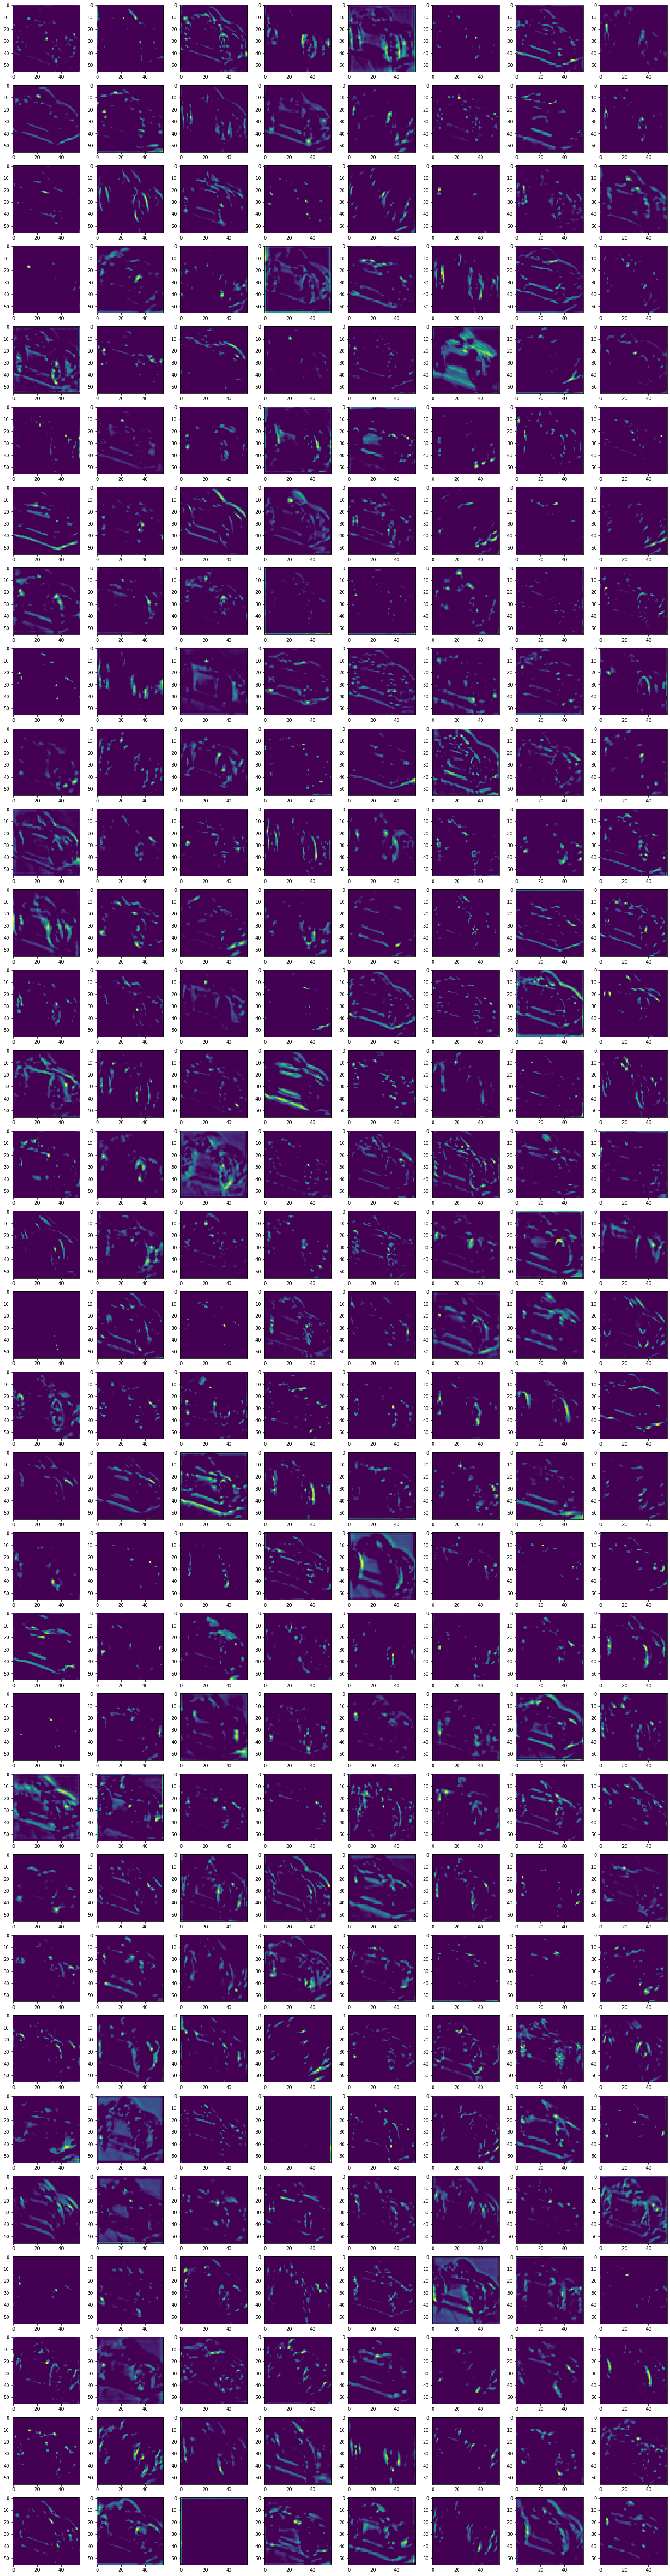

In [53]:
# Visualizing (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
# 256 x 56 x 56

plt.figure(figsize = (25, 100))
for i in range(activations[16][0].shape[0]):
  plt.subplot(32, 8, i+1)
  plt.imshow(activations[16][0][i].cpu())

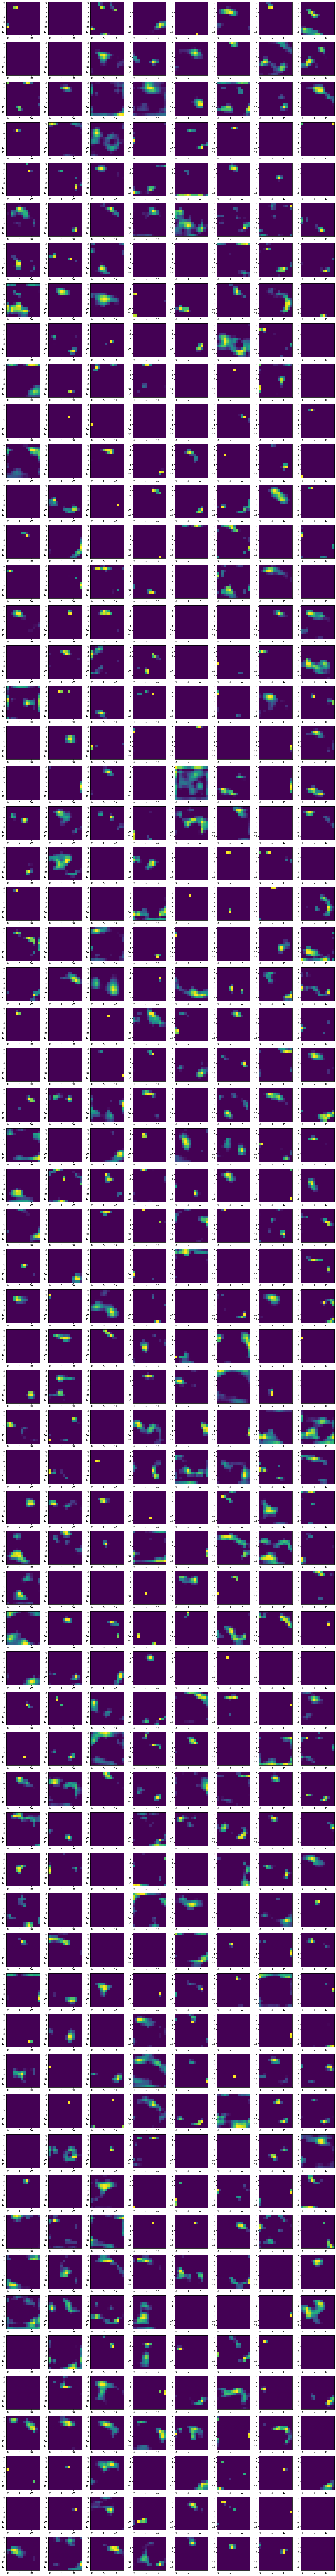

In [54]:
# Visualizing (34): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
# 512 x 14 x 14

plt.figure(figsize = (25, 200))
for i in range(activations[34][0].shape[0]):
  plt.subplot(64, 8, i+1)
  plt.imshow(activations[34][0][i].cpu())